In [1]:
%load_ext autoreload
%autoreload 2
import sys
phantom_path = '/Users/rkucharski/anaconda3/lib/node_modules/phantomjs-prebuilt/lib/phantom/bin/phantomjs'
import os 
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.3f}'.format
import numpy as np
from math import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import json
from scipy.stats import *
import os

import pprint
#colors = sns.color_palette("muted")

In [3]:
import folium
import h3
import webbrowser
from folium.plugins import HeatMap

In [4]:
plt.style.use(['science'])

* read results to a single dataframe

In [5]:
def res_reader(path = '../data/corona/results'):
    evolutions = list()
    last_days = list()
    populations = list()
    for filename in os.listdir(path):
        if filename.startswith('corona') or filename.startswith('population'):
            df = pd.read_csv(os.path.join(path,filename), index_col = 0)
            for h in filename[:-4].split("_")[1:]:
                field = h.split("-")[0]
                val = h.split("-")[1]
                try: 
                    val = float(val)
                except:
                    pass
                df[field]= val
            if filename.startswith('corona'):                
                df.index.name = 'day'
                last_days.append(pd.DataFrame(df.iloc[-1]).T)
                df = df.reindex(range(900)).fillna(method = 'ffill') 
                df['day'] = df.index.astype(int)              
                evolutions.append(df)
            elif filename.startswith('population'):
                populations.append(df)
    evolutions = pd.concat(evolutions)
    for col in ['I','Q','R','S','day', 'nP' , 'repl']:
        evolutions[col] = evolutions[col].fillna(0)
        evolutions[col] = evolutions[col].astype(int)
    populations = pd.concat(populations)
    last_days = pd.concat(last_days)
    last_days['day'] = last_days.index.astype(int)   
    for col in ['I','Q','R','S','day', 'nP' , 'repl']:
        last_days[col] = last_days[col].fillna(0)
        last_days[col] = last_days[col].astype(int)
    
    return evolutions, populations, last_days

evolutions, populations, last_days = res_reader(path = '../../data/corona/results')
evolutions_rev, populations_rev, last_days_rev = res_reader(path = '../../data/corona/rev')

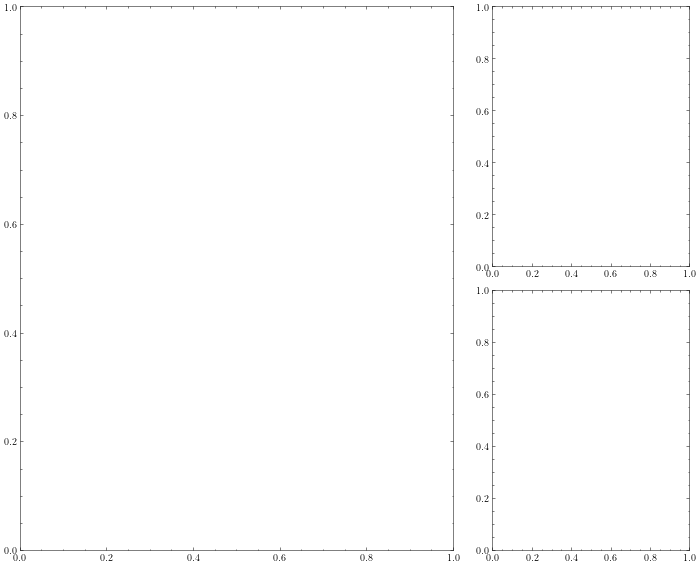

In [6]:
fig = plt.figure(constrained_layout=False, figsize=(12,10))
gs1 = fig.add_gridspec(nrows=4, ncols=3)
ax_boxes = fig.add_subplot(gs1[:, :-1])

ax_demand = fig.add_subplot(gs1[:-2, 2])
ax_occupancy = fig.add_subplot(gs1[-2:, 2])
#ax_scalinga = fig.add_subplot(gs1[2, 3])
#ax_scalingb = fig.add_subplot(gs1[3, 3])

* box plot figure

In [ ]:
p_text = 'participation probability $p$'
q_text = 'demand level $Q$'

# fig = plt.figure(constrained_layout=False, figsize=(8,8))
# gs1 = fig.add_gridspec(nrows=3, ncols=3)
# ax1 = fig.add_subplot(gs1[:, :-1])
# ax2 = fig.add_subplot(gs1[:-2, -1])
# ax3 = fig.add_subplot(gs1[1:, -1])
# axes = [ax1,ax2,ax3]

# fig = plt.figure(constrained_layout=False, figsize=(12,8))
# gs1 = fig.add_gridspec(nrows=4, ncols=5)
# ax_boxes = fig.add_subplot(gs1[:, :-2])

# ax_demand = fig.add_subplot(gs1[:, -2])
# ax_occupancy = fig.add_subplot(gs1[:2, -1])
# ax_scalinga = fig.add_subplot(gs1[2, -1])
# ax_scalingb = fig.add_subplot(gs1[3, -1])

fig = plt.figure(constrained_layout=False, figsize=(8,8))
gs1 = fig.add_gridspec(nrows=6, ncols=3)
ax_boxes = fig.add_subplot(gs1[:, :-1])

ax_demand = fig.add_subplot(gs1[:-2, -1])
ax_occupancy = fig.add_subplot(gs1[-2:, -1])


last_days['infection_effectiveness'] = (3200 - last_days.S) / (2000* last_days['init'])
last_days['infected'] = 3200- last_days.S
last_days['rel_infected'] = (3200 - last_days.S)  / 2000
last_days['initially infected'] = 2000* last_days.init
last_days['initially infected'] = last_days['initially infected'].astype(int)
last_days[p_text] = last_days['p']
sns.boxplot(x = p_text, y = 'infected', hue = 'initially infected', 
            ax = ax_boxes, data = last_days, linewidth=0.3 , 
            hue_order=[20, 10, 4, 2][::-1], showfliers = False)

df = evolutions_rev[evolutions_rev.experiment == 'EFFICIENCY']
df['occupancy'] = df['PassHourTrav']/df['VehHourTrav']+ 0.4
df['efficiency'] = -(df['VehHourTrav']- df['VehHourTrav_ns'])/df['VehHourTrav']
df[p_text] = df['p']

sns.scatterplot(x = p_text, y = 'occupancy' ,
            ax = ax_occupancy, data = df, linewidth=0.5, alpha = 0.2, color = 'black')
ax_occupancy.set_ylim(1,2)


last_days_rev = last_days_rev[last_days_rev.experiment == 'SCALING']
last_days_rev['infected'] = 3200 - last_days_rev.S
last_days_rev[q_text] = last_days_rev['nP']
last_days_rev['share infected'] = last_days_rev['infected']/last_days_rev[q_text]
last_days_rev[p_text] = last_days_rev['p']

means = last_days_rev.groupby(['demand level $Q$','p']).mean()
means['p'] = means.index.get_level_values(1)
means['demand level $Q$'] = means.index.get_level_values(0)


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

palette = sns.color_palette(colors[0:last_days_rev['p'].nunique()])
last_days_rev = last_days_rev
to_plot = last_days_rev

#sns.boxplot(x = 'demand $Q$', y = 'share infected', hue = 'p',
#            ax = axes[2], data = last_days_rev, linewidth=0.3, 
#            showfliers = False, whis=0.5)
# sns.lineplot(x = q_text, y = 'share infected', hue = 'p',
#             ax = ax_demand, data = to_plot, linewidth=1.5, palette = palette, ci = None)

#sns.lineplot(x = 'demand $Q$', y = 'share infected', hue = 'p',
#            ax = axes[2], data = last_days_rev)

#sns.lineplot(x = 'demand $Q$', y = 'infected', hue = 'p',
#            ax = axes[2], data = last_days_rev, linewidth=0.5)

#sns.scatterplot(x = q_text, y = 'share infected', hue = 'p', palette = palette, s = 8, alpha = 0.6,
#             ax = ax_demand, data = means, legend = True)

for i,p in enumerate(ps):    
    to_fit = last_days_rev[last_days_rev.p == p].groupby(q_text).mean()
    to_fit[q_text] = to_fit.index.copy()
    to_fit['log share'] = np.log(to_fit['share infected'])
    x = to_fit[q_text]
    y = to_fit['log share']
    sns.regplot(x = q_text, y = 'log share', color = colors[i],
             ax = ax_demand, data = to_fit, scatter_kws={'s':0, 'alpha':0.4}, ci = 0)
    x_fit = np.linspace(to_fit[q_text].min(),to_fit[q_text].max(),32)
    ax_demand.plot(x, y, 'ko', label=p, color = colors[i], alpha = 0.4, markersize=3)
    #ax.plot(x_fit, func(x_fit, *popt), 'r-', label=p, color = colors[i],alpha = 1, lw = 2)
    #ax.set_yscale('log')
    ax.set_xlim((300,3200))
    i+=1

#ax_demand.set_yscale('log')
#axes[2].set_xscale('log')
#axes[2].set_ylim((0,0.1))
ax_boxes.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax_boxes.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

ax_boxes.set_title(r'\textbf{a)} total number of infections')
ax_boxes.text(6.27,640,'2000 travellers',rotation=0, fontsize = 10)
ax_occupancy.set_title(r'\textbf{c)} ride-pooling efficiency')
ax_demand.set_title(r'\textbf{b}) demand scaling')
ax_demand.text(680,-3.37,'10 initial \n infections',rotation=0, fontsize = 10)
ax_demand.set_ylabel('share infected')
ax_demand.set_yticks([-4.654, -2.3])
ax_demand.get_yaxis().set_ticklabels(['$10^{-2}$','$10^{-1}$'])
ax_demand.legend()
#ax_demand.set_ylim((0.007,0.1))
#ax_demand.set_xlim((700,2500))
#ax_scalinga.set_title(r'\textbf{d}) exponential fit')

res = [[0.8, 1.1384542014838124, 0.003691279205519823],
       [0.85,0.9072328930464051, 0.004778451691240722],
       [0.9, 0.6904683484610271, 0.00550956044234896],
[0.95,0.48730032649687577, 0.005699568600636045],
[0.99,0.26145594104387404, 0.006160707423250162],
       [1           ,  0.18189964831395286, 0.00655140397855600]]
df = pd.DataFrame(res,columns = [r'participation probability $p$',r'$\alpha$', 'A'])

#sns.regplot(x = r'participation probability $p$',y=r'$\alpha$',data = df, color = 'red', ax = ax_scalinga, ci = None)
#sns.regplot(x = r'participation probability $p$',y='A',data = df, color = 'red', ax = ax_scalingb, ci = None)


plt.tight_layout() 
# plt.savefig('res_1.tiff', dpi = 600)
plt.savefig('fig_4.jpg', dpi = 600)
# plt.savefig('res_1.pdf', rasterized = True)

In [10]:
import numpy as np
from scipy.optimize import curve_fit
import scipy

In [11]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
p_text = 'participation probability $p$'
q_text = 'demand level $Q$'
last_days_rev = last_days_rev[last_days_rev.experiment == 'SCALING']
last_days_rev['infected'] = 3200 - last_days_rev.S
last_days_rev[q_text] = last_days_rev['nP']
last_days_rev['share infected'] = last_days_rev['infected']/last_days_rev[q_text]
last_days_rev[p_text] = last_days_rev['p']

last_days_rev= last_days_rev[last_days_rev['infected']>0]
last_days_rev[['p','demand level $Q$','share infected']].sort_values(['p',q_text]).to_csv('fits.csv')

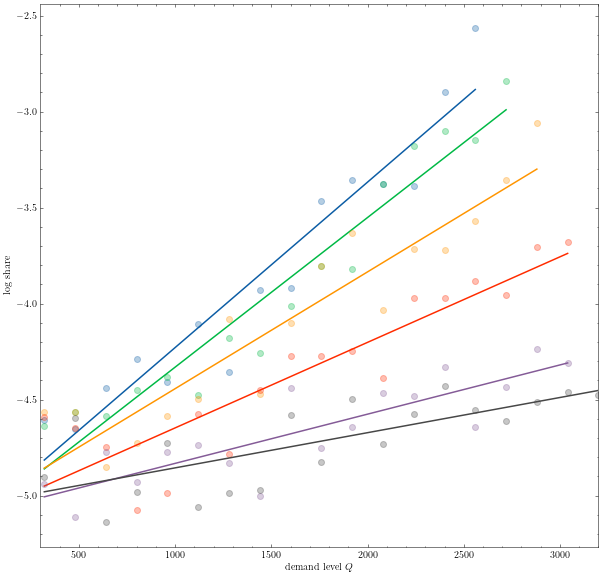

In [57]:
ps = [0.8,0.85,0.9,0.95,0.99,1]
i = 0
fig,ax = plt.subplots(figsize = (10,10))


def func(x, a, b):
    return a * np.exp((x/5000)*b) 

for p in ps:    
    to_fit = last_days_rev[last_days_rev.p == p].groupby(q_text).mean()
    to_fit[q_text] = to_fit.index.copy()
    to_fit['log share'] = np.log(to_fit['share infected'])
    x = to_fit[q_text]
    y = to_fit['log share']
    sns.regplot(x = q_text, y = 'log share', color = colors[i],
             ax = ax, data = to_fit, scatter_kws={'s':0, 'alpha':0.4}, label = p, ci = 0)
    x_fit = np.linspace(to_fit[q_text].min(),to_fit[q_text].max(),32)
    ax.plot(x, y, 'ko', label="Original Noised Data", color = colors[i], alpha = 0.3)
    #ax.plot(x_fit, func(x_fit, *popt), 'r-', label=p, color = colors[i],alpha = 1, lw = 2)
    #ax.set_yscale('log')
    ax.set_xlim((300,3200))
    i+=1
    




    

#sns.boxplot(x = 'demand $Q$', y = 'share infected', hue = 'p',
#            ax = axes[2], data = last_days_rev, linewidth=0.3, 
#            showfliers = False, whis=0.5)
#sns.lineplot(x = q_text, y = 'share infected', hue = 'p',
#            ax = axes[2], data = to_plot, linewidth=1.5, palette = palette, ci = None)

/Users/rkucharski/anaconda3/envs/maassim/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.


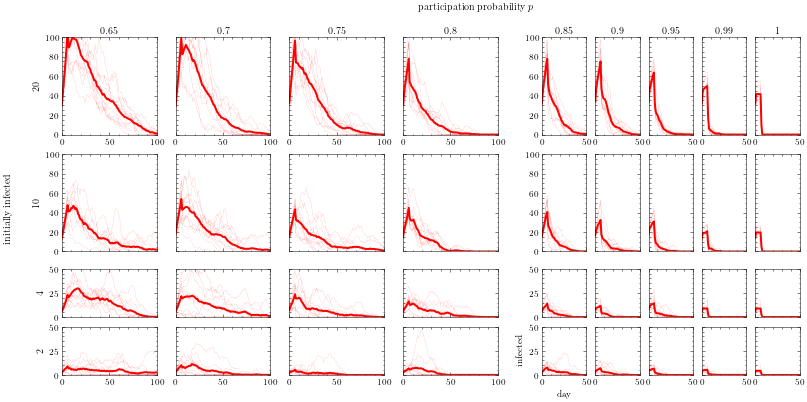

In [9]:
evolutions['initially infected'] = 2000* evolutions.init
evolutions['initially infected'] = evolutions['initially infected'].astype(int)
plt.rcParams['figure.figsize'] = [18, 19]
# font = {'size'   : 12}

# plt.rc('font', **font)
#plt.rcParams['figure.facecolor'] = 'white'
#plt.rcParams['axes.facecolor'] = 'white'
#fig, axes = plt.subplots(4,len(evolutions.p.unique()), sharey = True, sharex = True)
fig = plt.figure()
axes = list()
widths = [2,2,2,2,1,1,1,1,1]
heights = [2,2]
for row in range(2):
    axes += [fig.add_subplot(9,9,1+9*row)]
    axes += [fig.add_subplot(9,9,2+9*row)]
    axes += [fig.add_subplot(9,9,3+9*row)]
    axes += [fig.add_subplot(9,9,4+9*row)]
    axes += [fig.add_subplot(9,19,10+19*row)]
    axes += [fig.add_subplot(9,19,11+19*row)]
    axes += [fig.add_subplot(9,19,12+19*row)]
    axes += [fig.add_subplot(9,19,13+19*row)]
    axes += [fig.add_subplot(9,19,14+19*row)]
for row in [2,3]:
    axes += [fig.add_subplot(18,9,1+9*(row+2))]
    axes += [fig.add_subplot(18,9,2+9*(row+2))]
    axes += [fig.add_subplot(18,9,3+9*(row+2))]
    axes += [fig.add_subplot(18,9,4+9*(row+2))]
    axes += [fig.add_subplot(18,19,10+19*(row+2))]
    axes += [fig.add_subplot(18,19,11+19*(row+2))]
    axes += [fig.add_subplot(18,19,12+19*(row+2))]
    axes += [fig.add_subplot(18,19,13+19*(row+2))]
    axes += [fig.add_subplot(18,19,14+19*(row+2))]
axes = np.array(axes).reshape(4,9)  
fig.text(0.4, 0.9,p_text)
fig.text(0.08, 0.73, 'initially infected',rotation='vertical')
   
j = -1
for share in [20, 10, 4, 2]:
    df = evolutions[evolutions['initially infected'] == share]
    df = df[df.day<200]
    j += 1
    i=-1
    for p in [0.65, 0.7, 0.75,  0.8,  0.85, 0.9, 0.95, 0.99, 1]: 

        i +=1
        for repl in df[df.p == p].repl.unique():
            to_plot = df[(df.repl == repl) & (df.p == p)]
            to_plot.I.plot(ax=axes[j][i], lw = 0.2, color = 'red', alpha = 0.4)
            #to_plot.R.plot(ax=axes[j][i], lw = 0.3, color = 'green', alpha = 0.3)
        #to_plot = populations[populations.repl == repl]
        #plot_heat_infection(to_plot,axes[1][i], cbar = p ==0.99)
        #axes[1][i].set_xlim(0,800)
        #axes[1][i].set_ylim(0,200)
        to_plot = df[(df.p == p)]
        to_plot['d'] = to_plot['day']
        to_plot = to_plot.groupby('d')
        
        to_plot = to_plot.I.mean()
        
        to_plot.plot(ax=axes[j][i], lw = 2, color = 'red')
        #to_plot.R.mean().plot(ax=axes[j][i], lw = 2, color = 'green')

        if share == 20:
            axes[j][i].set_xlabel(p)
            axes[j][i].get_xaxis().set_label_position('top') 
        elif share == 2:
            axes[j][i].set_xlabel('') 
            
        else:
            axes[j][i].set_xlabel('')            
            axes[j][i].get_xaxis().set_ticklabels([])
        if p in [0.65]:
            axes[j][i].set_ylabel(share, rotation=90)
        elif p in [0.85]:
            if share == 2:
                axes[j][i].set_ylabel('infected', fontsize = 9)
                axes[j][i].set_xlabel('day', fontsize = 9)
        else:
            axes[j][i].get_yaxis().set_ticklabels([])
        axes[j][i].tick_params(axis='both', which='major', labelsize=9)
        axes[j][i].set_xlim((0,100 if p<0.85 else 50))
        axes[j][i].set_ylim((0,100 if share>5 else 50))

plt.tight_layout(rect=[0, 0.05, 0.95, 0.95])
plt.savefig('res_2.png', bbox_inches="tight", dpi = 600)
plt.savefig('res_2.jpg', bbox_inches="tight", dpi = 600)
plt.savefig('res_2.tiff', bbox_inches="tight", dpi = 600)

* 3 figures on degree evolution and mitigation

/Users/rkucharski/anaconda3/envs/maassim/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


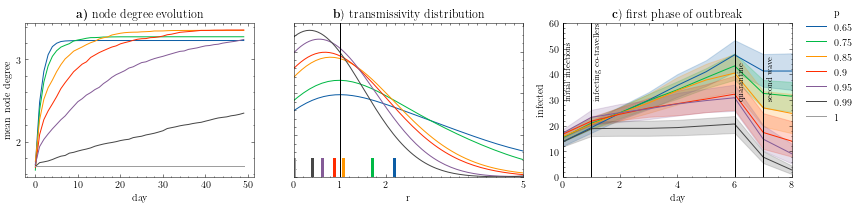

In [10]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
palette = sns.color_palette(colors)
populations['initially infected'] = 2000 * populations.init
populations['initially infected'] = populations['initially infected'].astype(int)
ps = [0.65,0.75,0.85,0.9, 0.95,0.99,1]
populations = populations[populations.p.isin(ps)]
plt.style.use(['science'])
fig, axes = plt.subplots(1,3,figsize = (12,3))



#font = {'size'   : 10}
#plt.rc('font', **font)
#plt.rcParams["font.family"] = "Helvetica"
#colors = sns.color_palette("gist_yarg", 9)
share = 10
i=-1

for p in ps: 
    i+=1
    df = populations[populations['initially infected'] == share]
    to_plot = df[(df.p == p)]
    to_plot['r'] = to_plot.apply(lambda x: None if pd.isnull(x.infection_day) else len(to_plot[to_plot.infected_by == x.name]), axis = 1)      
    to_plot = to_plot.dropna()

    to_plot['r'] = to_plot['r'].astype(int)
    sns.distplot(to_plot.r, kde = True, ax = axes[1], hist = False, 
                        norm_hist = False, hist_kws = {"alpha":  0.5}, kde_kws={'bw': 1}, color = palette[i],
                        bins=np.arange(to_plot.r.min(), to_plot.r.max() + 1))
    
    axes[1].axvline(to_plot['r'].mean(),0,0.12, lw = 3, color = palette[i])
    #ax.axvline(x = to_plot.r.mean(), lw = 1, color = colors[i])
    #ax.text(x=to_plot.r.mean(), y = 0.43,s = p,rotation=90)
axes[1].set_xlim(0,15)

d = pd.read_csv('../../data/corona/degrees.csv', index_col = 0)
d['y'] = d['mean']-0.8
d = d[d.p.isin(ps)]
#p = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 1]
repl = 0
#for repl in range(10):
#    sns.lineplot(data =d[d.repl == repl],y = 'mean', x='day', hue = 'p', palette =sns.color_palette("gist_yarg", 9), lw = 0.5, alpha = 0.3, ax = ax, legend = False)
sns.lineplot(data =d[d.repl == repl],y = 'y', x='day', hue = 'p', palette =palette, lw = 1, ax = axes[0], markers = None)


axes[0].set_ylabel('mean node degree')
axes[1].set_ylabel('')
axes[1].set_yticklabels([])


evolutions['initially infected'] = 2000* evolutions.init
evolutions['initially infected'] = evolutions['initially infected'].astype(int)
evolutions['infected'] = evolutions.I
evolutions['day '] = evolutions['day']
plt.rcParams['figure.figsize'] = [6, 4]
sns.lineplot(data = evolutions[(evolutions['initially infected']==10) & (evolutions.day<=8) &  (evolutions.day>=0) & (evolutions['p']<1)], 
             x = 'day ', y = 'infected', 
             hue = 'p', hue_order = ps, palette =palette, ax = axes[2])



axes[0].get_legend().remove()
axes[1].set_xlim(0,5)
axes[2].set_xlim(0,45)

#axes[1].get_legend().remove()
axes[2].legend(bbox_to_anchor=(1.3, 0.3),loc='lower right')

axes[0].set_title(r'\textbf{a)} node degree evolution')
axes[1].set_title(r'\textbf{b}) transmissivity distribution')
axes[2].set_title(r'\textbf{c}) first phase of outbreak')


axes[2].axvline(0,color = 'black')
axes[2].set_ylim(0,60)
axes[2].set_xlim(0,8)
axes[2].text(0.05,30,'initial infections',rotation=90, fontsize = 8)
axes[2].axvline(1,color = 'black')
axes[2].text(1.1,30,'infecting co-travellers',rotation=90, fontsize = 8)
axes[2].axvline(6,color = 'black')
axes[1].axvline(1,color = 'black')
axes[2].text(6.1,30,'quarantine',rotation=90, fontsize = 8)
axes[2].axvline(7,color = 'black')
axes[2].text(7.1,30,'second wave',rotation=90, fontsize = 8)


axes[0].set_yticks([2,3])
axes[1].yaxis.grid(False, which='both')
axes[1].set_yticklabels([])
axes[1].set_xticks([0,1, 2, 5])
axes[1].set_yticklabels([])

plt.tight_layout()
plt.savefig('3res.png', dpi = 600)
plt.savefig('3res.jpg', dpi = 600)
plt.savefig('3res.tiff', dpi = 600)


* spatial extent


In [12]:
from IPython.display import Image
import selenium.webdriver
from geojson.feature import *

In [13]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw , ImageOps

In [11]:
import ExMAS.utils
from ExMAS.utils import inData as inData
params = ExMAS.utils.get_config('../../data/configs/default.json') # load the default 
params.city = 'Amsterdam, Netherlands'
params.t0 = '17:00'
params.paths.G = '../../data/graphs/Amsterdam.graphml'
params.paths.skim = '../../data/graphs/Amsterdam.csv'
nodes = ExMAS.utils.load_G(inData, params, stats=True).nodes  # download the graph

In [12]:
requests = pd.read_csv('../../data/corona/requests.csv')
requests.shape

(3200, 11)

In [13]:
APERTURE_SIZE = 8
requests = pd.read_csv('../../data/corona/requests.csv')
requests['ox'] = requests.apply(lambda r: inData.nodes.loc[r.origin].x, axis =1)
requests['oy'] = requests.apply(lambda r: inData.nodes.loc[r.origin].y, axis =1)
requests['dx'] = requests.apply(lambda r: inData.nodes.loc[r.destination].x, axis =1)
requests['dy'] = requests.apply(lambda r: inData.nodes.loc[r.destination].y, axis =1)
requests['hex_o'] = requests.apply(lambda x: h3.geo_to_h3(x.oy,x.ox,APERTURE_SIZE),1)
requests['hex_d'] = requests.apply(lambda x: h3.geo_to_h3(x.dy,x.dx,APERTURE_SIZE),1)
hexes = pd.Series(list(set(list(requests.hex_o.unique())+list(requests.hex_d.unique())))).to_frame('hex_id')
hexes['geom'] = hexes.apply(lambda x: {"type": "Polygon","coordinates": [h3.h3_to_geo_boundary(h = x.hex_id, geo_json = True)]}, axis = 1)
hexes = hexes.set_index('hex_id')
hexes['hex_id'] = hexes.index.copy()

In [24]:
def heat(requests, hexes, repl = None, od = 'hex_o', col = 'count', image = False):
    if repl is None:
        repl = populations.repl.sample(1).values[0]
    population = populations[populations.repl == repl]
    data = population[population.infection_day>=-3]
    data[od] = requests.loc[data.index][od].values
    hexes['count'] = data.groupby(od).size()
    hexes['day'] = data.groupby(od).infection_day.min()
    hexes['hex_id'] = hexes.index.copy()
    hexes = hexes[hexes['count']>0]
    
    list_features = []
    for i, row in hexes.iterrows():
        feature = Feature(geometry = row["geom"],
                          id = row["hex_id"],
                          properties = {"resolution": 9})
        list_features.append(feature)
        
    CENTER = [52.3703923, 4.877417]
    tile = 'cartodbpositron'

    feat_collection = FeatureCollection(list_features)
    geojson_hexes = json.dumps(feat_collection)
    base_map = folium.Map(location=CENTER, zoom_start=13,tiles=tile, zoomControl =  False)
    if col == 'count':
        m = folium.Choropleth(geo_data = geojson_hexes,data = hexes, columns = ['hex_id',col],key_on ="feature.id",
            control = False, fill_color = 'YlOrBr', bins = [-1, 0, 100,1000], #0, 1, 2, 5, 10, 20],
            fill_opacity=1, line_opacity=0.1).add_to(base_map)
    else:
        m = folium.Choropleth(geo_data = geojson_hexes,data = hexes, columns = ['hex_id',col],key_on ="feature.id",
            control = False, fill_color = 'RdPu', bins = [-1, 0, 1, 5, 10, 20, 40, 60],
            fill_opacity=1, line_opacity=0.1).add_to(base_map)

    for key in m._children:
        if key.startswith('color_map'):
            del(m._children[key])
    if not image:
        return base_map
    else:
        pix = 1000
        base_map.save('map.html')
        driver = selenium.webdriver.PhantomJS(executable_path=phantom_path)
        driver.set_window_size(pix, pix)  # choose a resolution
        driver.get('map.html')
        # You may need to add time.sleep(seconds) here
        filename = '../../data/corona/maps/{}_{}_{}.png'.format(col, population.p.max(),repl)
        driver.save_screenshot(filename)
        del base_map
        del driver
        
        #return Image(filename=filename) 

for p in [0.65, 0.7, 0.75,  0.8,  0.85, 0.9, 0.95, 0.99, 1]: 
     for i in range(5):
            repl = populations[(populations.p == p) & (populations['initially infected'] == 2)].repl.sample(1).values[0]
            #try:
            base_map = heat(requests, hexes, repl = repl, image = True)
            #except:
            #    pass
heat(requests, hexes,  image = False)

IndexError: list index out of range

In [15]:
def make_collage(size = 500, level = 9, big = False, file_header = 'HEXES'):
    names = ['1.png','2.png','3.png','5.png','6.png','7.png']
    names = names[::-1]
    rows = 1
    cols = 6
    header = 50
    FIELDS = ['p = 0.65','0.7','0.75','0.85','0.9', '0.95', '1']
    #names = ['a) PT travel time','b) Uber travel time', 'c) Time Gap', 'd) Cost Gap', 'e) Uber added value' ]
    city_names = ['', 'Warsaw, PL', 'Stockholm, SE']
    filename = 'res_6.jpg'
    for CITIES in [['Amsterdam', 'Warsaw', 'Stockholm'],['DC', 'Houston', 'NYC']]:
        new_im = Image.new('RGB', (size*cols+3*header,size*rows+2*header), (255,255,255))
        font = ImageFont.truetype("Avenir.ttc", 30)
        draw = ImageDraw.Draw(new_im)
        for i in range(0,size*cols,size):
            shift = 0
            if names[int(i/size)] in ['Time Gap']:
                shift = header
            if names[int(i/size)] == 'Cost Gap':
                shift = 50
            if names[int(i/size)] == 'Uber added value':
                shift = header+50
            draw.text((int(header)+i+10+shift, 20),FIELDS[int(i/size)],(0,0,0),font=font)
            for j in range(0,size*rows,size):
                PATH = 'maps/'+names[int(i/size)]
                #'../data/results/figs/{}_{}_{}_{}.png'.format(file_header, level, CITIES[int(j/size)],  FIELDS[int(i/size)])
                print(PATH, j, size)
                im = Image.open(PATH)
                im.thumbnail((size*0.99,size*0.99))
                if i == 0:
                    txt=Image.new('L', (250,50))
                    d = ImageDraw.Draw(txt)
                    d.text( (0, 0), city_names[int(j/size)],  font=font, fill=255)
                    w=txt.rotate(90,  expand=1)
                    new_im.paste( ImageOps.colorize(w, (0,0,0), (0,0,0)), (int(header/3),j+int(size/2)),  w)
                new_im.paste(im, (header+i+int(size/100)+shift,header+j+int(size/100)))
#         im = Image.open('../data/results/figs/scale_1.png')
#         im.thumbnail((size*0.8,header))
#         new_im.paste(im, (400,3*size+header))
#         im = Image.open('../data/results/figs/scale_2.png')
#         im.thumbnail((size*0.8,header))
#         new_im.paste(im, (header+1400,3*size+header))
#         im = Image.open('../data/results/figs/scale_3.png')
#         im.thumbnail((size*0.8,header))
#         new_im.paste(im, (header+2150,3*size+header))
        new_im.save(filename)
make_collage()        
        

maps/7.png 0 500
maps/6.png 0 500
maps/5.png 0 500
maps/3.png 0 500
maps/2.png 0 500
maps/1.png 0 500
maps/7.png 0 500
maps/6.png 0 500
maps/5.png 0 500
maps/3.png 0 500
maps/2.png 0 500
maps/1.png 0 500
